# Exploration

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import IPython.display as ipd

import utils

In [5]:
AUDIO_DIR = 'data/fma_small'

tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [7]:
# Get fma_small metadata
small_tracks = tracks[tracks['set', 'subset'] <= 'small']
small_tracks.shape

### You can load the waveform and listen to audio in the notebook itself.

In [12]:
filename = utils.get_audio_path(AUDIO_DIR, 2)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: data/fma_small/000/000002.mp3


/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.98s, 1321967 samples


And use librosa to compute spectrograms and audio features.

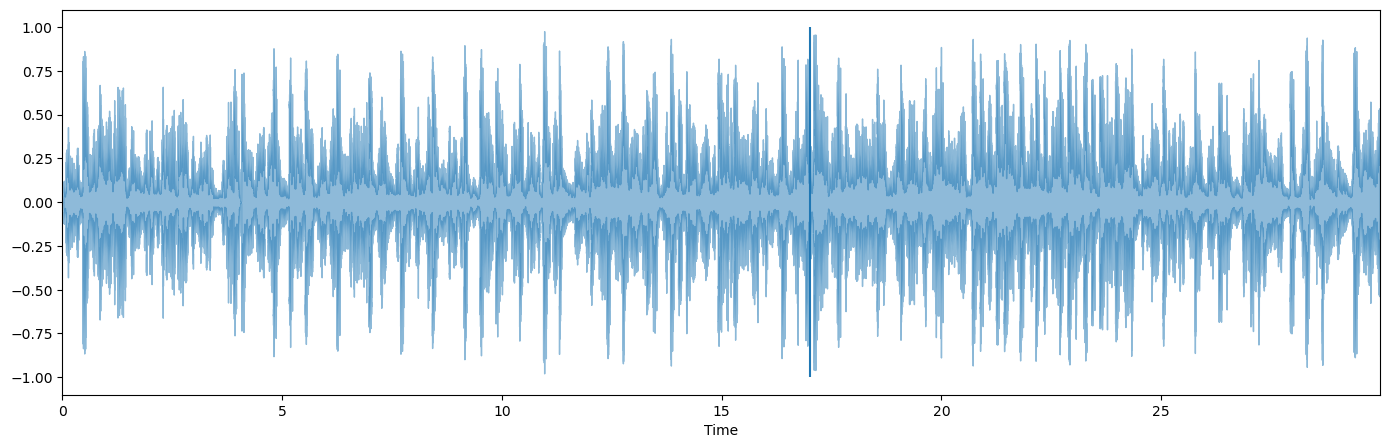

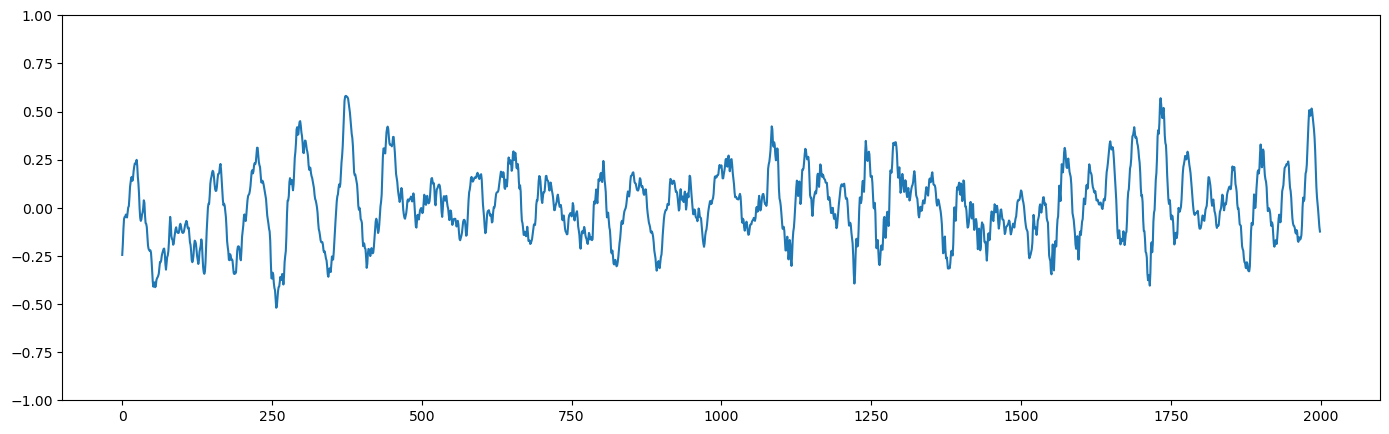

In [18]:
plt.rcParams['figure.figsize'] = (17, 5)

librosa.display.waveplot(x, sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));

## Genre Classification

In [23]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [24]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 46.38%
